In [1]:
import sqlite3
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

from bgfunc import *

loading data/LIWC/LIWC2007_English100131_words.dic
loading LIWC with stopVal=0.5, for 906 words
loading data/LIWC/LIWC2007_English100131_words.dic
loading LIWC with stopVal=0.0, for 4483 words
loading LabMT with stopVal=1.0, for 3731 words
loading ANEW with stopVal=1.0, for 765 words


/Users/andrew/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
dbfile = 'project_june10_705pm.db'
conn = sqlite3.connect(dbfile)

In [3]:
platform = 'ig' # ig = instagram, tw = twitter
condition = 'ptsd' # depression, pregnancy, ptsd, cancer

In [21]:
specs = analysis_specifications(platform, condition)

platform_long = specs['plong'][platform]
gb_types = specs['gb_types'][platform]
fields = specs['fields'][platform] 
test_name = specs['test_name'][condition]
test_cutoff = specs['test_cutoff'][condition]
photos_rated = specs['photos_rated'][condition]
has_test = specs['has_test'][condition]

clfs = ['rf'] # lr = logistic regression, rf = random forests, svc = support vector
periods = ['before']
turn_points = ['from_diag']

#################
#
# INSTAGRAM ONLY 
# 
#################
additional_data = False # (instagram only) do we also get photo ratings? (This is proxy for limit_date_range in places)

include_filter = True # (instagram only) include binary indicator of filter use? 

include_face_data = True # (instagram only) include has_face and face_ct? 

get_ratings_correlation = False # (instagram only) gets inter-rater correlation averages for each rated variable 

compare_ig_filters = False # (instagram only) compares use of filters between target and control pops

#################
#
# TWITTER ONLY 
# 
#################
populate_wordfeats_db = False # (twitter only) generates word features from reagan code 

#################
#
# ALL PLATFORMS 
# 
#################
impose_test_cutoff = True # do we want to limit target pop based on testing cutoff (eg. cesd > 21)?

limit_date_range = False # do we want to restrict posts by date range? 

posting_cutoff = False # Drops usernames with fewer than (mean - 0.5std) total posts (for mcmc p-val improvement)

report_sample_size = False # simple reporting feature for sample size

report_sm_disq = False # reports #/% of subjects disqualified for refusing to share social media data

share_sm_disq_fnames = ["../../data/final/depressioninstagram_round1.csv",
                       "../../data/final/depressioninstagram_round2.csv",
                       "../../data/final/controlinstagram.csv"]

path_head = '/'.join(['data-files',condition,platform])+'/'

load_from = None # None, file, pickle :: loads masters from pickled file, or just masters from csv

write_to = None # None, file, pickle  :: writes initial data (prepare_raw_data()) to csv or pickle

final_pickle = True # pickles entire data dict after all masters are created

make_hourly_plot = False # make plot of aggregated hourly posting for target vs control?

run_master = True 
run_subsets = True
run_separate_pca = True

action_params = {
    'create_master': True, 
    'save_to_file' : False, 
    'density' : False, 
    'ml' : False, 
    'nhst' : False, 
    'corr' : False, 
    'print_corrmat' : False,
    'tall_plot': False, # (random forest) do we have enough variables to require a taller plot window?
    'acc_avg': 'binary', # (ml) accuracy score basis for f1, precision, etc. "binary" or "weighted"
    'use_ttest':False, # (nhst) compute t-tests for each variable?
    'best_pca':10, # (pca) how many components to use?
    'show_pca_comp_plot':True, # (pca) show scree plot?
    'rf_imp_cutoff':.015, # (random forest) show feats with importance >= X
    'rf_imp_subset':10 # (random forest) show top X important feats
}

params = define_params(condition, test_name, test_cutoff, impose_test_cutoff,
                       platform, platform_long, fields, photos_rated, has_test, additional_data)

In [22]:
if not load_from: # construct data dict from raw data
    data = make_data_dict(params, condition, test_name, conn)
    prepare_raw_data(data, platform, params, conn, gb_types, condition, 
                     periods, turn_points, posting_cutoff,
                     additional_data=additional_data, include_filter=include_filter, limit_date_range=limit_date_range)
else: # load data dict from saved file
    data = pickle.load(open("{path}{cond}_{pl}_data.p".format(path=path_head,
                                                              cond=condition,
                                                              pl=platform), "rb" ) )

TARGET DATA:
Shape of consolidated TARGET ALL data: (6476, 20)
Note: Number of actual data points will be lower for ratings...see get_descriptives()

('Subset shape for IG BEFORE FROM_DIAG:', (2996, 21))
('Subset shape for IG BEFORE FROM_SUSP:', (976, 21))

CONTROL DATA:
Shape of consolidated CONTROL ALL data: (22811, 20)
Note: Number of actual data points will be lower for ratings...see get_descriptives()



In [42]:
if run_master:
    master = data['master']
    target = data['target']['gb']
    control = data['control']['gb'] 
    report = 'MAIN'
    
    if action_params['create_master']:
        master['model'] = {}

    for gb_type in ['created_date']:

        master_actions(master, target, control, condition, platform, 
                       params, gb_type, report, action_params, clfs, additional_data, posting_cutoff)


Merge to master: MAIN created_date
master created_date shape: (17833, 12)



In [44]:
use_pca = False # should models be fit using orthogonal pca components?

if run_subsets:
    action_params['compare_filters'] = False
    for period in ['before']:
        if action_params['create_master']:
            data['master'][period] = {}

        for turn_point in ['from_diag']:    
            if action_params['create_master']:
                data['master'][period][turn_point] = {}

            master = data['master'][period][turn_point]
            target = data['target'][period][turn_point]['gb']
            control = data['control']['gb'] 
            report = '{}_{}'.format(period,turn_point)

            if action_params['create_master']:
                master['model'] = {}

            for gb_type in ['created_date']:
                print 'Reporting for: SUBSETS'
                print 'Period: {}  Focus: {}  Groupby: {}'.format(period.upper(), turn_point.upper(), gb_type.upper())
                # merge target, control, into master
                master_actions(master, target, control, condition,
                               platform, params, gb_type, report,
                               action_params, clfs, additional_data, posting_cutoff,
                               use_pca=use_pca) # using PCA?

Reporting for: SUBSETS
Period: BEFORE  Focus: FROM_DIAG  Groupby: CREATED_DATE

Merge to master: before_from_diag created_date
master created_date shape: (16112, 12)



In [45]:
data['target']['all']['has_face'] = None
data['target']['all']['face_ct'] = None

In [46]:
data['control']['all']['has_face'] = None
data['control']['all']['face_ct'] = None

In [47]:
print 'target shape:', data['target']['all'].shape
print 'control shape:', data['control']['all'].shape

target shape: (6476, 21)
control shape: (22811, 21)


In [27]:
# imports for face detect
import cv2
import os
import sys
from string import Template
import urllib
import numpy as np
import pandas as pd

from os import listdir
from os.path import isfile, join
import filecmp
from IPython.display import Image, display
import pickle
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [28]:
def find_faces(row, pop, condition):
    url = row['url']
    path_url = url.split('//scontent.cdninstagram.com/')[1].replace('/','___') + ".jpg"
    savepath = '/'.join(["photos",condition,pop,"{}".format(path_url)])
    
    if not isfile(savepath):
        urllib.urlretrieve(url, savepath)
    
    row['has_face'], row['face_ct'] = face_detect(savepath)

    return row

In [29]:
def face_detect(img):
    ''' Detects faces in a photograph using Haar cascades '''
    ''' Modified from source: https://gist.github.com/dannguyen/cfa2fb49b28c82a1068f '''
    
    # first argument is the haarcascades path
    face_cascade_path = "../../haarcascade_frontalface_default.xml"
    face_cascade = cv2.CascadeClassifier(face_cascade_path)

    # profiles didn't work better than default (and also didn't catch things default missed)
    #profile_cascade_path = "../../haarcascade_profileface.xml"
    #profile_cascade = cv2.CascadeClassifier(profile_cascade_path)

    scale_factors = [1.05, 1.4] # you played around and found these two runs to be the best
    min_neighbors = 4 # you experimented between 1 and 5 here, 4 seemed best.
    min_size = (20,20) # don't go higher than this, many tiny faces
    flags = cv2.CASCADE_SCALE_IMAGE

    image = cv2.imread(img)

    found_face = False
    face_ct = 0
    
    for scale in scale_factors:
        if not found_face:
            scale_factor = scale
            for cascade, view in [(face_cascade,'straight')]:#[(face_cascade,'straight'),(profile_cascade,'profile')]:
                faces = cascade.detectMultiScale(image, 
                                                scaleFactor = scale_factor, 
                                                minNeighbors = min_neighbors,
                                                minSize = min_size, 
                                                flags = flags)
                if len(faces) != 0:
                    found_face = True
                    face_ct += len(faces)

                    for ( x, y, w, h ) in faces:
                        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 255, 0), 2)
                        savedir = '/'.join(['photos',condition,pop,'detected',view])
                        savefname = img.split('/')[-1] + ".jpg"
                        savepath = join(savedir,savefname)
                        cv2.imwrite(savepath, image)
                    
    return(found_face, face_ct)            

In [30]:
def show_photo(url, pop, pred_face, doPrint=True):
    ''' Displays photo in Jupyter notebook for face assessment '''
    
    if pred_face:
        path_head = "photos/depression/{}/detected/straight".format(pop)
    else:
        path_head = "photos/depression/{}".format(pop)
        
    new_fname = url.split('//scontent.cdninstagram.com/')[1].replace('/','___') + ".jpg"
    
    if doPrint:
        print new_fname
    
    path = join(path_head, new_fname)
    
    try:
        display(Image(filename=path))
    except:
        display(Image(filename=path+'.jpg'))

## Running face detection

In [31]:
## this is the main function for pulling down photos from url and finding faces in them!
## it takes a long time to run all photos in the depression set (hours)

for pop in ['target','control']:
    #pop = 'control'
    data[pop]['all'] = data[pop]['all'].apply(find_faces, axis=1, args=(pop, condition))

pickle.dump( data, open( "with_face_data_{}.p".format(condition), "wb" ) )

In [231]:
## updates db with has_face and face_ct fields
## (only do this once)

#with conn:
#    cur = conn.cursor()
#    cur.execute('alter table meta_ig add column has_face int')
#    cur.execute('alter table meta_ig add column face_ct int')
#    conn.commit()

In [32]:
## uploads face data into meta_ig

tmp = data['target']['all'][['has_face','face_ct','url']].copy()
tmp.has_face = tmp.has_face.astype(int)
tmp.url = tmp.url.astype(str)

tmp2 = data['control']['all'][['has_face','face_ct','url']].copy()
tmp2.has_face = tmp2.has_face.astype(int)
tmp2.url = tmp2.url.astype(str)

tmp3 = pd.concat([tmp,tmp2])

tups = [tuple(x) for x in tmp3[['has_face','face_ct','url']].values]

q = 'update meta_ig set has_face = ?, face_ct = ? where url = ?'
with conn:
    cur = conn.cursor()
    cur.executemany(q, tups)
    conn.commit() 

## Creating validation sample sets

In [33]:
## get all data with face ratings for condition

condition = 'ptsd'
q = 'select username, url, has_face, face_ct, d_from_diag_{cond} as diagdate, d_from_susp_{cond} as suspdate from meta_ig where has_face is not null'.format(cond=condition)
a = pd.read_sql_query(q, conn)
a = a.ix[a.url.isin(tmp3.url),:]
print 'Face ratings for {}'.format(condition), a.shape

## break down into control/target claim-yes-face/claim-no-face

cmask = a.diagdate.isnull()
tmask = a.diagdate.notnull()
facemask = a.has_face

cnotf = a.ix[cmask & ~facemask,:].copy()
# control face predicted
chasf = a.ix[cmask & facemask,:].copy()

# target no face predicted
tnotf = a.ix[tmask & ~facemask,:].copy()
# target face predicted
thasf = a.ix[tmask & facemask,:].copy()

Face ratings for ptsd (29287, 6)


In [34]:
print "control pop:", cnotf.shape[0] + chasf.shape[0]

control pop: 22811


In [35]:
print "target pop:", tnotf.shape[0] + thasf.shape[0]

target pop: 6476


In [36]:
## get 100-observation sample from one at a time
## set current to determine which group you're reviewing

current = thasf

current['actual_has_face'] = None
current['actual_face_ct'] = None
current['actual_face_obstruct'] = None
current['actual_face_toosmall'] = None
current_sample = current.sample(100).reset_index(drop=True)

samp = current_sample

## Assessing faces manually

t51.2885-15___s320x320___e35___11849903_974976915858920_2068426891_n.jpg.jpg


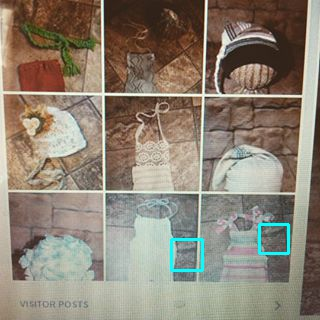

In [37]:
## this block actually displays a photo to assess

# set pop based on target or control
pop = 'target'
# set pred_face based on whether you're looking at a sample that claimed faces vs claimed no faces
pred_face = True




# go one at a time!
url_num = 99




show_photo(samp.url[url_num], pop, pred_face)

In [1259]:
## report results from photo

actual_has_face      = 0
actual_face_count    = 0

actual_face_obstruct = 0 # these are counts
actual_face_toosmall = 0 # these are counts


samp.ix[url_num, 'actual_has_face'] = bool(actual_has_face)
if not bool(actual_has_face):
    samp.ix[url_num, 'actual_face_ct'] = 0
else:
    samp.ix[url_num, 'actual_face_ct'] = actual_face_count
    samp.ix[url_num, 'actual_face_obstruct'] = actual_face_obstruct
    samp.ix[url_num, 'actual_face_toosmall'] = actual_face_toosmall

## Bringing together validation sets for analysis

In [38]:
# brings all four sample classes together [ target/control, pred_face/pred_no_face ]
allf = pd.concat([thasf, tnotf])
allf = pd.concat([allf, chasf])
allf = pd.concat([allf, cnotf])

allf.shape

aa = a.ix[a.url.isin(allf.url),:].reset_index(drop=True).copy()
allf2 = pd.merge(allf,aa, on=['url','has_face','face_ct','diagdate','username'], how='inner')

# just a check, shouldn't change 
print 'before dropna:', allf2.shape
print 'after dropna:', allf2.dropna(subset=['username']).shape

before dropna: (29287, 11)
after dropna: (29287, 11)


In [39]:
def get_face_stats(subset, when='before', gb_type='created_date'):
    ''' Reports descriptive stats for face detection in given population subset '''
    
    if subset == 'main':
        aset = data['master'][gb_type]
        subdf = 'main'
    else:
        subdf = "from_{}".format(subset)
        col = "{}_{}".format(when, subset)
        turn = '{}date'.format(subset)

        aset = data['master'][when][subdf][gb_type].reset_index()

        
    # masks for all depression (target + control)
    t_mask = aset.target==1
    c_mask = aset.target==0
    
    print 'face ct avg (target):', aset.ix[t_mask,'face_ct'].mean()
    print 'face ct std (target):', aset.ix[t_mask,'face_ct'].std()
    print
    print 'face ct avg (control):', aset.ix[c_mask,'face_ct'].mean()
    print 'face ct std (control):', aset.ix[c_mask,'face_ct'].std()
    
    
    #aset = a.ix[a.username.isin(bdate.username) & (a[turn].isnull() | (a[turn]<0)),:]

    print
    print 'For all data (not just validation samples...):'
    print '{} set size: {}'.format(subdf,aset.shape[0])
    print 'target set size:', aset.ix[t_mask,:].shape[0]
    print 'control set size:', aset.ix[c_mask,:].shape[0]
    print
    print
    
    print 'Prop HAS FACE for TARGET:', round(aset.ix[t_mask, 'has_face'].mean(), 3)
    print 'Std prop HAS FACE for TARGET:', round(aset.ix[t_mask, 'has_face'].std(), 3)
    print
    print 'Prop HAS FACE for CONTROL:', round(aset.ix[c_mask, 'has_face'].mean(), 3)
    print 'Std prop HAS FACE for CONTROL:', round(aset.ix[c_mask, 'has_face'].std(), 3)

    print
    print

    print 'Considering all photos with at least one face...'
    print
    print 'Mean FACE CT for TARGET:', round(aset.ix[t_mask & (aset.face_ct>0), 'face_ct'].mean(), 3)
    print 'STD FACE CT for TARGET:', round(aset.ix[t_mask & (aset.face_ct>0), 'face_ct'].std(), 3)
    print
    print 'Mean FACE CT for CONTROL:', round(aset.ix[c_mask & (aset.face_ct>0), 'face_ct'].mean(), 3)
    print 'STD FACE CT for CONTROL:', round(aset.ix[c_mask & (aset.face_ct>0), 'face_ct'].std(), 3)

    print
    print

    print 'ttest for has_face:'
    tout = ttest(aset.ix[t_mask, 'has_face'], aset.ix[c_mask, 'has_face'])
    print 't = {}, p = {}'.format(tout.statistic, tout.pvalue)
    print

    print 'ttest for face_ct:'
    tout = ttest(aset.ix[t_mask & (aset.face_ct>0), 'face_ct'], aset.ix[c_mask & (aset.face_ct>0), 'face_ct'])
    print 't = {}, p = {}'.format(tout.statistic, tout.pvalue)
    
    print 'ttest for face_ct all photos:'
    tout = ttest(aset.ix[t_mask, 'face_ct'], aset.ix[c_mask, 'face_ct'])
    print 't = {}, p = {}'.format(tout.statistic, tout.pvalue)

In [48]:
subset = "diag" # takes values: from_diag, from_susp, main

get_face_stats(subset)

face ct avg (target): 0.898863123741
face ct std (target): 1.31864942551

face ct avg (control): 0.6508186099
face ct std (control): 1.00834326261

For all data (not just validation samples...):
from_diag set size: 16112
target set size: 1521
control set size: 14591


Prop HAS FACE for TARGET: 0.857
Std prop HAS FACE for TARGET: 1.152

Prop HAS FACE for CONTROL: 0.618
Std prop HAS FACE for CONTROL: 0.843


Considering all photos with at least one face...

Mean FACE CT for TARGET: 1.516
STD FACE CT for TARGET: 1.413

Mean FACE CT for CONTROL: 1.347
STD FACE CT for CONTROL: 1.08


ttest for has_face:
t = 10.1469750502, p = 4.0390907455e-24

ttest for face_ct:
t = 4.24507200575, p = 2.21008448743e-05
ttest for face_ct all photos:
t = 8.83832790714, p = 1.07036643155e-18


In [51]:
# masks for samples
mask_t = allf2.diagdate.notnull()
mask_c = ~mask_t

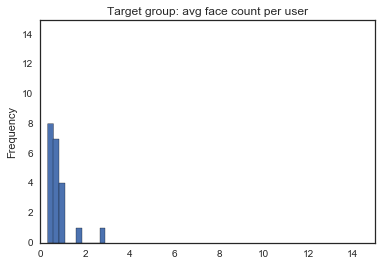

In [52]:
## checking to make sure we don't have any high-face-posting outliers in depression group that would explain diff

(allf2.ix[mask_t, :]
      .groupby('username')
      .agg({'face_ct':'mean'})['face_ct']
      .plot(kind='hist', 
            bins=10, 
            xlim=(0,15), 
            ylim=(0,15),
            title="Target group: avg face count per user"))

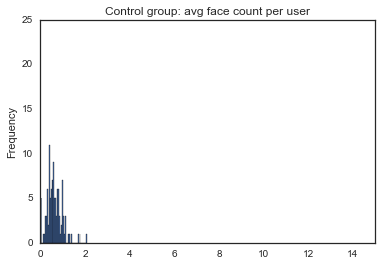

In [53]:
## actually, we have a high-posting outlier in control!  without it results would be same but more extreme

(allf2.ix[mask_c, :]
      .groupby('username')
      .agg({'face_ct':'mean'})['face_ct']
      .plot(kind='hist', 
            bins=50, 
            xlim=(0,15), 
            ylim=(0,25),
            title="Control group: avg face count per user"))

In [1371]:
print 'For validation samples:'
print

print 'TARGET :: true negative :: has_face:', 1 - allf2.ix[mask_t & ~allf2.has_face, 'actual_has_face'].mean()
print 'CONTROL :: true negative :: has_face:', 1 - allf2.ix[mask_c & ~allf2.has_face, 'actual_has_face'].mean()

print 

print 'TARGET :: true positive :: has_face:', allf2.ix[mask_t & (allf2.has_face), 'actual_has_face'].mean()
print 'CONTROL :: true positive :: has_face:', allf2.ix[mask_c & allf2.has_face, 'actual_has_face'].mean()

For validation samples:

TARGET :: true negative :: has_face: 0.77
CONTROL :: true negative :: has_face: 0.79

TARGET :: true positive :: has_face: 0.585858585859
CONTROL :: true positive :: has_face: 0.61


In [1393]:
## Looking at face ct accuracy differences between target and controls

t_ct = allf2.ix[mask_t , 'face_ct'].values
t_act_ct = allf2.ix[mask_t , 'actual_face_ct'].values

print 'TARGET face ct vs actual face ct MEAN DIFF ct-act_ct', np.mean( t_ct - t_act_ct)
print 'TARGET face ct vs actual face ct STD', np.std(t_ct - t_act_ct)
mse = mean_squared_error(t_ct, t_act_ct)
print 'TARGET face ct vs actual face ct MSE', mse

print
print

c_ct = allf2.ix[mask_c , 'face_ct'].values
c_act_ct = allf2.ix[mask_c , 'actual_face_ct'].values

print 'CONTROL face ct vs actual face ct MEAN DIFF ct-act_ct', np.mean( c_ct - c_act_ct)
print 'CONTROL face ct vs actual face ct STD', np.std(c_ct - c_act_ct)
mse = mean_squared_error(c_ct, c_act_ct)
print 'CONTROL face ct vs actual face ct MSE', mse

TARGET face ct vs actual face ct MEAN DIFF ct-act_ct -0.015
TARGET face ct vs actual face ct STD 1.21027889348
TARGET face ct vs actual face ct MSE 1.465


CONTROL face ct vs actual face ct MEAN DIFF ct-act_ct -0.215
CONTROL face ct vs actual face ct STD 2.06852000232
CONTROL face ct vs actual face ct MSE 4.325


In [54]:
## logistic regression with has_face, face_ct as predictors

a['target'] = None
a.ix[a.diagdate.notnull(), 'target'] = 1
a.ix[a.diagdate.isnull(), 'target'] = 0

dm = pd.DataFrame(a[['has_face','face_ct']].copy())
dm = sm.add_constant(dm)
logit = sm.Logit(a.target.astype(int).values, dm)
# fit the model
result = logit.fit()
print result.summary()

Optimization terminated successfully.
         Current function value: 0.528197
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                29287
Model:                          Logit   Df Residuals:                    29284
Method:                           MLE   Df Model:                            2
Date:                Mon, 15 Aug 2016   Pseudo R-squ.:               0.0002412
Time:                        07:09:44   Log-Likelihood:                -15469.
converged:                       True   LL-Null:                       -15473.
                                        LLR p-value:                   0.02394
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -1.2849      0.018    -70.264      0.000        -1.321    -1.249
has_face       0.0152      0.

In [796]:
print 'dnotf: missed 4 out of 100 (not including too small or obstructed)'
print 'cnotf: missed 6 out of 100 (not including too small or obstructed)'

dnotf: missed 4 out of 100 (not including too small or obstructed)
cnotf: missed 6 out of 100 (not including too small or obstructed)


## Makeup samples for controls with missing images

In [789]:
## use this block for samples where no face was found, and where some images just fail to load

#new_samp_size = 100-total.shape[0] 
#sample2 = [insert_current_df_like_cnotf...].sample(new_samp_size).reset_index(drop=True)



## in these cases, you took a new sample to make up the no-load photos, so each sample total still summed to 100
## this code block concats the earlier sample and the makeup sample set.

# dhasf_sample = samp
# dhasf_sample['pop'] = 'target'

#tmp = dnotf_sample.copy()
#tmp.dropna(subset=['actual_has_face'], inplace=True)
#tmp = pd.concat([tmp, samp], axis=0)
#tmp.dropna(subset=['actual_has_face']).shape

## now pickle file to disk

#pickle.dump(allf,open('allf.p','wb'))

(100, 8)

In [1398]:
# when you originally did this for depression, allf2 ended up being a corrected version of allf validation sample data.  
# 'allf2_USE_THIS_ALLF.p' is the right file to use if you need the validation samples from depression.

#pickle.dump(allf2,open('allf2_USE_THIS_ALLF.p','wb'))